In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore # for scaling the data
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [0]:
columns=['Sex','Length','Diameter','Height','Whole_weight','Shucked_weight','Viscera_weight','Shell_weight','Rings']

In [0]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Kmeans on Marine Snails/abalone.data',header=None,names=columns)
X=df.drop(columns='Sex')

In [21]:
X.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [19]:
df.isnull().sum()# No Null values

Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


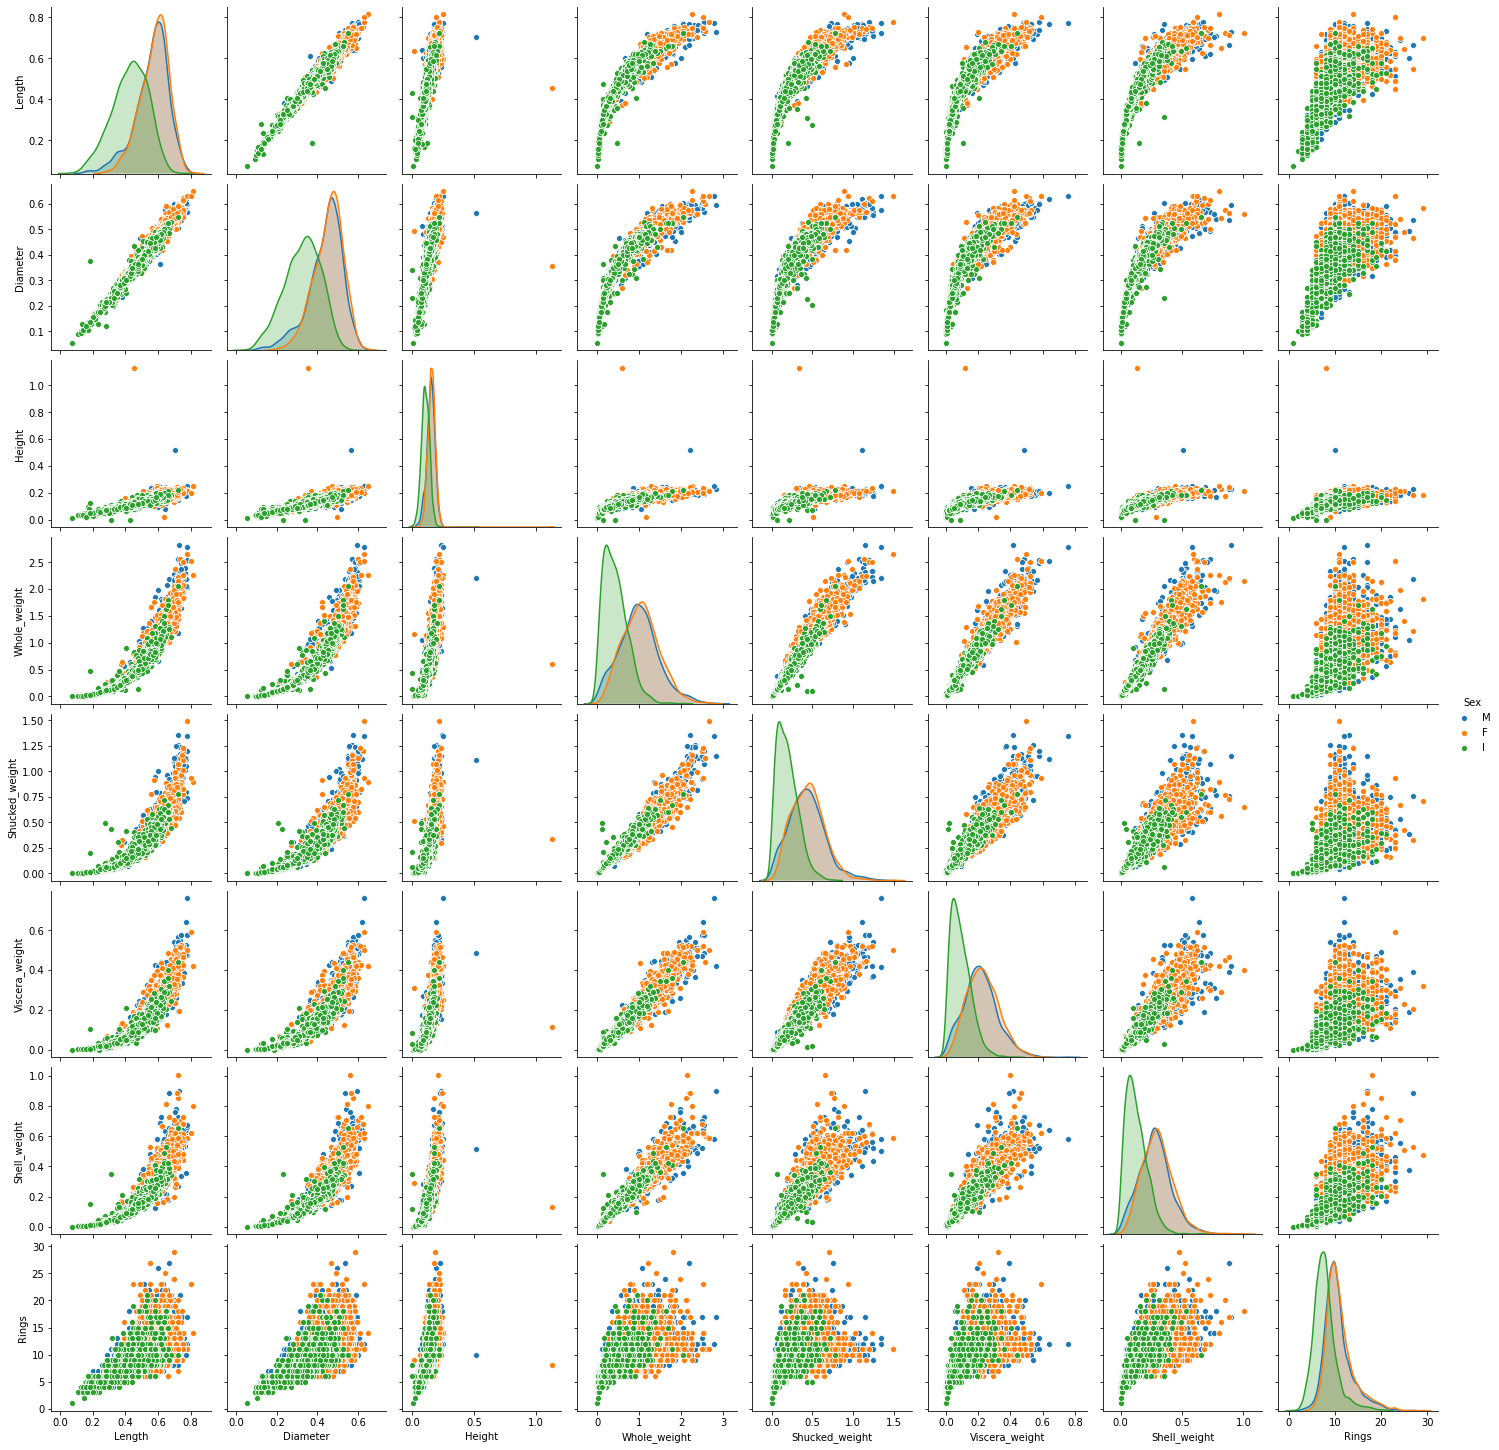

In [24]:
sns.pairplot(df,diag_kind='kde',hue='Sex')
plt.show()
# Here we can see 3 clusters with one cluster clearly visible while 2 are overlapping
#Length is giving good demarcation for 3 clusters

In [0]:
df_scaled = X.apply(zscore)


In [31]:
# Taking range from 1 to 14 for clusters and checking inertia in each case
cluster_range = range( 1, 15 )
cluster_errors = []
for num_clusters in cluster_range:
  clusters = KMeans( num_clusters,n_init = 15, random_state=2)
  clusters.fit(df_scaled)
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  cluster_errors.append( clusters.inertia_ )
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:15]

,num_clusters,cluster_errors
0,1,33416.000000
1,2,14612.656454
2,3,9922.820301
3,4,7867.637683
4,5,6799.355134
5,6,5837.344511
6,7,5282.140473
7,8,4752.506312
8,9,4287.613412
9,10,3928.945864


The total sum of squared distances of every data point from respective centroid is also called inertia. Above we have printed the inertia value for all K values. That K at which the inertia stop to drop significantly (elbow method) will be the best K.

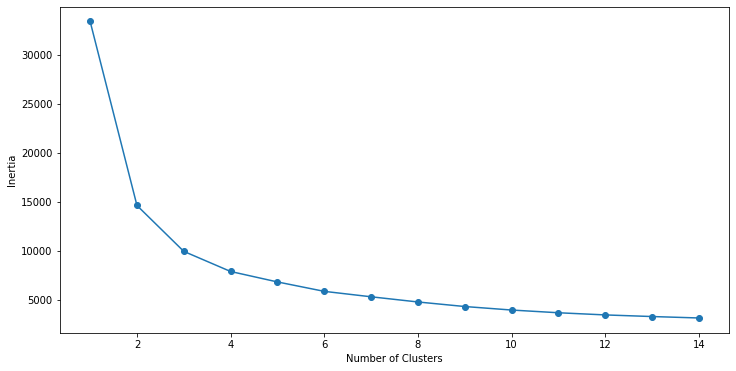

In [34]:
# Elbow plot
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

As we know this is a labeled dataset and we have 3 genders so we will go with 3 clusters otherwise in absence of labels, we would have built model for 3 & 4 clusters both and checked whichever is giving better clusters

In [37]:
kmeans = KMeans(n_clusters=3, n_init = 15, random_state=2)
kmeans.fit(df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)

In [38]:
centroids=kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns = list(df_scaled) )
centroid_df

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,1.035409,1.041185,0.980001,1.220030,1.176567,1.196843,1.174955,0.619436
1,-1.277100,-1.277873,-1.120858,-1.137503,-1.084084,-1.115910,-1.128333,-0.857175
2,0.134651,0.131173,0.068912,-0.085939,-0.091465,-0.084288,-0.060884,0.142583


From above centroid, we can figure out which centroid is for which cluster. Let's take Lenght as the feature to compare 3 centroid values as it was giving good demarcation in EDA.


*   Cluster 0- Length very high
*   Cluster 1- Length very low
*   Cluster 2- Length moderate

On doing some research on the domain on marine snails or abalone, we found that females have are larger in length in comparison to males so by this logic
*   Cluster 0- Females
*   Cluster 1 - Infant
*   Cluster 2 - Males






In [0]:
df_labels=pd.DataFrame({'labels':kmeans.labels_})
df_join=df_scaled.join(df_labels)

In [51]:
#Label count obtained through Kmeans
df_join.labels.value_counts()

2    1774
0    1225
1    1178
Name: labels, dtype: int64

In [52]:
#Original Dataset Label count
df.Sex.value_counts()

M    1528
I    1342
F    1307
Name: Sex, dtype: int64

Above we can also see kmeans did fairly a good job in segragating into 3 clusters as number of data points in each cluster obtained through Kmeans is close to the actual data points in original dataset

In [39]:
kmeans.inertia_ #Inertia for 3 clusters

9922.820301027994

Applying PCA on dataset and then Kmeans

In [59]:
#By default np.cov calculates covariance row wise but we want column wise so we take transpose
cov_matrix=np.cov(df_scaled.T)
cov_matrix.shape

(8, 8)

In [60]:
cov_matrix

array([[1.00023946, 0.98704789, 0.82775178, 0.92548274, 0.89812868,
        0.90323394, 0.89792054, 0.55685289],
       [0.98704789, 1.00023946, 0.83388332, 0.92567371, 0.89337636,
        0.89993988, 0.90554657, 0.57479746],
       [0.82775178, 0.83388332, 1.00023946, 0.81941695, 0.77515787,
        0.79851047, 0.81753374, 0.55760082],
       [0.92548274, 0.92567371, 0.81941695, 1.00023946, 0.96963759,
        0.96660649, 0.95558422, 0.54051908],
       [0.89812868, 0.89337636, 0.77515787, 0.96963759, 1.00023946,
        0.93218449, 0.88282841, 0.42098444],
       [0.90323394, 0.89993988, 0.79851047, 0.96660649, 0.93218449,
        1.00023946, 0.90787367, 0.5039399 ],
       [0.89792054, 0.90554657, 0.81753374, 0.95558422, 0.88282841,
        0.90787367, 1.00023946, 0.62772433],
       [0.55685289, 0.57479746, 0.55760082, 0.54051908, 0.42098444,
        0.5039399 , 0.62772433, 1.00023946]])

In [63]:
df.corr()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole_weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucked_weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera_weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell_weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


In [0]:
eig_val,eig_vec=np.linalg.eig(cov_matrix)

In [73]:
df_eig_vec=pd.DataFrame(eig_vec)
df_eig_vec

,0,1,2,3,4,5,6,7
0,0.372139,0.068283,0.031070,-0.604054,0.698826,-0.016349,-0.047497,0.011125
1,0.373094,0.040048,0.041005,-0.587595,-0.712985,0.000219,-0.023375,-0.057911
2,0.340027,-0.070463,0.899706,0.256777,0.008614,-0.002688,0.026691,0.056729
3,0.378307,0.137346,-0.206194,0.241849,-0.008331,-0.850264,0.117255,-0.015656
4,0.362454,0.298840,-0.208286,0.183246,-0.009282,0.391101,0.624893,0.398525
5,0.368558,0.172979,-0.197380,0.265221,-0.027346,0.204179,-0.765844,0.309821
6,0.370758,-0.045400,-0.161574,0.244192,0.047395,0.285624,0.032832,-0.830564
7,0.242713,-0.921204,-0.192144,0.043310,0.008421,0.023370,0.068196,0.220026


In [0]:
eig_val=sorted(eig_val,reverse=True)#eig values tell the variance or spread of each eigen vector

In [77]:
total=np.sum(eig_val)
var_exp=[(i/total) for i in eig_val]
cumvar_exp=np.cumsum(var_exp)
cumvar_exp
#We can see here only by first 4 eigen vectors are explaining 97.9 variance in data so we can safely ignore the rest

array([0.83905489, 0.92600651, 0.9583119 , 0.97906064, 0.98967934,
       0.99761344, 0.99920021, 1.        ])

In [0]:
eigen_pairs=[(np.abs(eig_val[i]),eig_vec[:,i]) for i in range(len(eig_val))]

In [0]:
#Sorting eig vectors on the basis of their eig values
eigen_pairs_sorted=sorted(eigen_pairs,reverse=True)


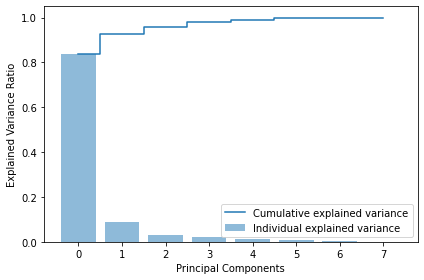

In [93]:
#Cumulative variance explained by PCs
plt.figure(figsize=(6 , 4))
plt.bar(range(8), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(8), cumvar_exp, where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [0]:
eig_val_sort=[eigen_pairs_sorted[i][0] for i in range(len(eigen_pairs_sorted))]
eig_vec_sort=[eigen_pairs_sorted[i][1] for i in range(len(eigen_pairs_sorted))]

In [0]:
#Keeping the first PC only as it explains 83 % variance
P_reduce=np.array(eig_vec_sort[:1]).transpose()

In [120]:
P_reduce

array([[0.3721385 ],
       [0.37309411],
       [0.34002678],
       [0.37830748],
       [0.36245449],
       [0.3685578 ],
       [0.37075782],
       [0.24271277]])

In [121]:
Proj_data_pca=np.dot(df_scaled,P_reduce)
Proj_data_pca.shape

(4177, 1)

In [123]:
Proj_data_pca=pd.DataFrame(Proj_data_pca, columns = ['PC1'])
Proj_data_pca.head()

,PC1
0,-1.322914
1,-3.483651
2,-0.536161
3,-1.458054
4,-3.766906


In [124]:
kmeans_pca = KMeans(n_clusters=3, n_init = 15, random_state=2)
kmeans_pca.fit(Proj_data_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=2, tol=0.0001, verbose=0)

In [125]:
centroids_pca=kmeans_pca.cluster_centers_
centroid_pca_df = pd.DataFrame(centroids_pca, columns = ['PC1'] )
centroid_pca_df

,PC1
0,3.082402
1,-3.118459
2,0.128527


In [0]:
df_pca_labels=pd.DataFrame({'labels':kmeans_pca.labels_})
df_join_pca=Proj_data_pca.join(df_pca_labels)

In [127]:
df_join_pca.labels.value_counts()

2    1763
1    1236
0    1178
Name: labels, dtype: int64

In [128]:
df.Sex.value_counts()

M    1528
I    1342
F    1307
Name: Sex, dtype: int64

In [129]:
kmeans_pca.inertia_ # earlier inertia was 9922.820301027994

4786.761413253249

The inertia has reduced by half on applying Kmeans on single PC component